# Official False Low Clouds Index
* SST (NOAA)
* air temp and moisture (GFS)
* data repackaged into more efficient netcdf files
* netcdf files are read for the FLC index

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import datetime
import os

time = "00z"

root = "/home/jturner/false_low_clouds_2023/Model/Time_Lapse/time_"+time+"/"

#ftime = "03z"
#root = "/home/jturner/false_low_clouds_2023/Model/Forecast/time_"+time+"_"+ftime+"/"

# Run analysis of processed data

In [2]:
date = '20220219'

sst_file = root+date+"/oisst-avhrr-v02r01."+date+".nc"

sst_ds = xr.open_dataset(sst_file)
sst_ds =  sst_ds.squeeze()
sst_ds.sst.values = sst_ds.sst.values+273.15

In [3]:
t = xr.open_dataset(root+date+'/t_'+date+'.nc')
q = xr.open_dataset(root+date+'/q_'+date+'.nc')

Region for analysis:

In [4]:
#--- Northeast US
min_lon = -83
min_lat = 26
max_lon = -51
max_lat = 50

#-- Oaxaca
# min_lon = -109
# min_lat = 10
# max_lon = -81
# max_lat = 24

In [5]:
sst_ds = sst_ds.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon+360,max_lon+360))
t = t.sel(latitude=slice(min_lat,max_lat), longitude=slice(min_lon+360,max_lon+360))
q = q.sel(latitude=slice(min_lat,max_lat), longitude=slice(min_lon+360,max_lon+360))

In [6]:
begin = sst_ds.sst.shape[0]
end = sst_ds.sst.shape[1]

dims = t.t[0:begin,0:end]

diff = t.t[0:begin,0:end].values - sst_ds.sst[:,:].values

In [7]:
bottom_lim = -4

diff_np = np.asarray(diff).copy()
under_zero = diff_np < bottom_lim
diff_np[under_zero] = bottom_lim

In [8]:
top_T = 4

diff_norm = diff_np/(top_T - bottom_lim)

In [9]:
top_q = 0.016
bottom_q = 0.000
q_norm = (q.q[0:begin,0:end].values)/(top_q - bottom_q)
q_norm_av = (q.q[0:begin,0:end].values)/(top_q - bottom_q)

In [10]:
flc_index = diff_norm*q_norm

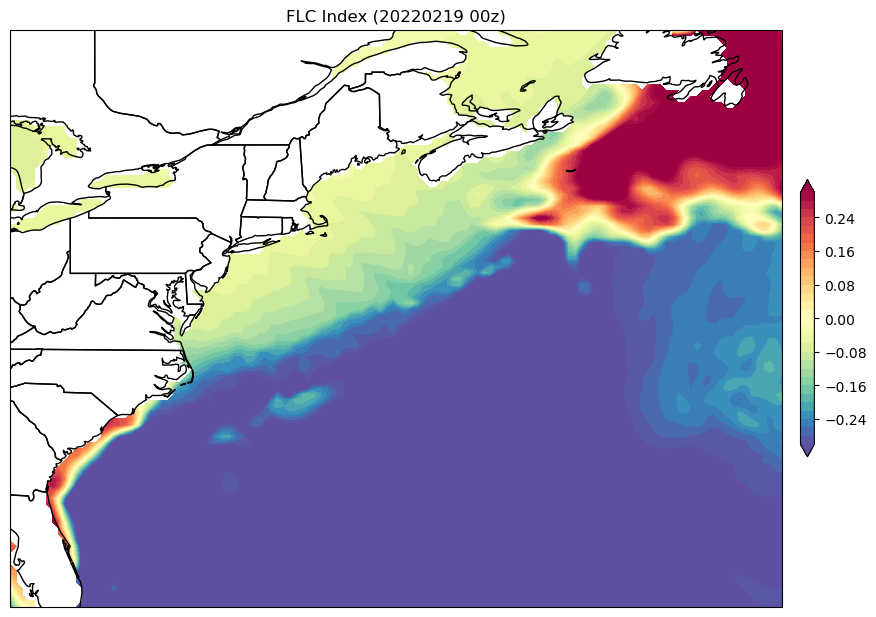

In [11]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Spectral_r
levels = np.linspace(-0.3, 0.3, 31)

c=ax.contourf(dims.longitude, dims.latitude, flc_index, cmap=cmap, levels=levels, extend='both')
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('FLC Index ('+date+' '+ time+')')
clb.set_label('')

#ax.coastlines(resolution='110m')
#ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)

#plt.savefig('/Users/jesseturner/Downloads/flc_index_'+date+'.png', dpi=300)

**Bulk loading pre-made data**

In [12]:
def FLC_warn_xarray(date):
    
    sst_file = root+date+"/oisst-avhrr-v02r01."+date+".nc"
    sst_ds = xr.open_dataset(sst_file)
    sst_ds =  sst_ds.squeeze()
    sst_ds.sst.values = sst_ds.sst.values+273.15
    
    t = xr.open_dataset(root+date+'/t_'+date+'.nc')
    q = xr.open_dataset(root+date+'/q_'+date+'.nc')
    
#---Region for analysis
#     min_lon = -126 + 360
#     min_lat = 24.5
#     max_lon = -64 + 360
#     max_lat = 49.5
  
#---Commented out for global analysis
#     sst_ds = sst_ds.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
#     t = t.sel(latitude=slice(min_lat,max_lat), longitude=slice(min_lon,max_lon))
#     q = q.sel(latitude=slice(min_lat,max_lat), longitude=slice(min_lon,max_lon))

    begin = sst_ds.sst.shape[0]
    end = sst_ds.sst.shape[1]

    dims = t.t[0:begin,0:end]

    diff = t.t[0:begin,0:end].values - sst_ds.sst[:,:].values

    bottom_lim = -4

    diff_np = np.asarray(diff).copy()
    under_zero = diff_np < bottom_lim
    diff_np[under_zero] = bottom_lim

    top_T = 4

    diff_norm = diff_np/(top_T - bottom_lim)

    top_q = 0.016
    bottom_q = 0.000
    q_norm = (q.q[0:begin,0:end].values)/(top_q - bottom_q)
    q_norm_av = (q.q[0:begin,0:end].values)/(top_q - bottom_q)

    flc_index = diff_norm*q_norm

    #---Building the xarray dataset
    
    row_meshgrid, col_meshgrid = np.meshgrid(dims.latitude, dims.longitude, indexing='ij')

    ds = xr.Dataset(
        data_vars=dict(
            flc_index=(["x","y"], flc_index)
        ),
        coords=dict(
            latitude=(["x","y"], row_meshgrid),
            longitude=(["x","y"], col_meshgrid),
        ),
        attrs=dict(description="FLC index in the designated region"),
    )
    
    ds = ds.expand_dims(dim={"time": 1})
    
    return ds

Add the datetimes in here, set to the year in question: 

In [13]:
year = '2022'

In [14]:
FLC_3d_xarray = []
dates = []

for filename in os.listdir(root):
    #print(filename)
    if (filename[0:4] == year): 
        FLC_3d_xarray.append(FLC_warn_xarray(filename))
        
        dates.append(datetime.datetime(int(filename[0:4]), int(filename[4:6]), int(filename[6:8])))
    

In [15]:
da_concat = xr.concat(FLC_3d_xarray, pd.Index(dates, name='time'))

Positive FLC index: Setting all negative FLC index to zero

In [16]:
da_concat = da_concat.where(da_concat.flc_index > 0, 0)

Summing the total FLC index

In [17]:
tot = da_concat.sum(dim='time')

In [18]:
flc_above = tot.flc_index.where(tot.flc_index > 0.15)

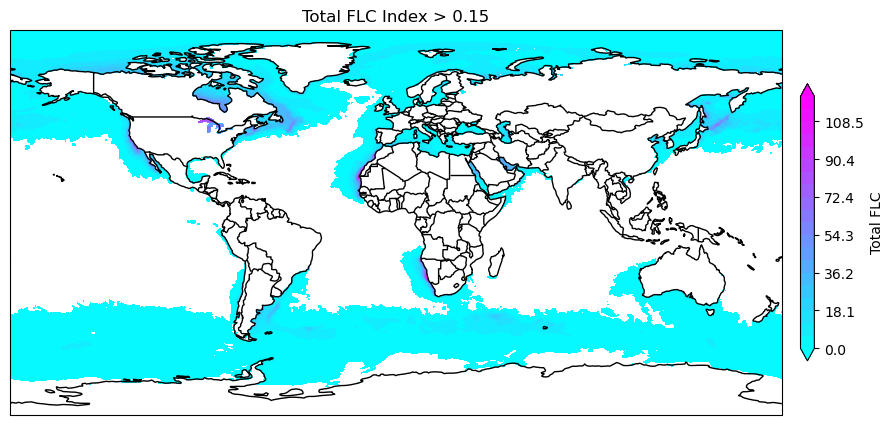

In [19]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.cool
levels = np.linspace(0, np.amax(flc_above), 21)

ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS)
c=ax.contourf(flc_above.longitude[0,:], flc_above.latitude[:,0], flc_above, cmap=cmap, levels=levels, extend='both')
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Total FLC Index > 0.15')
clb.set_label('Total FLC')

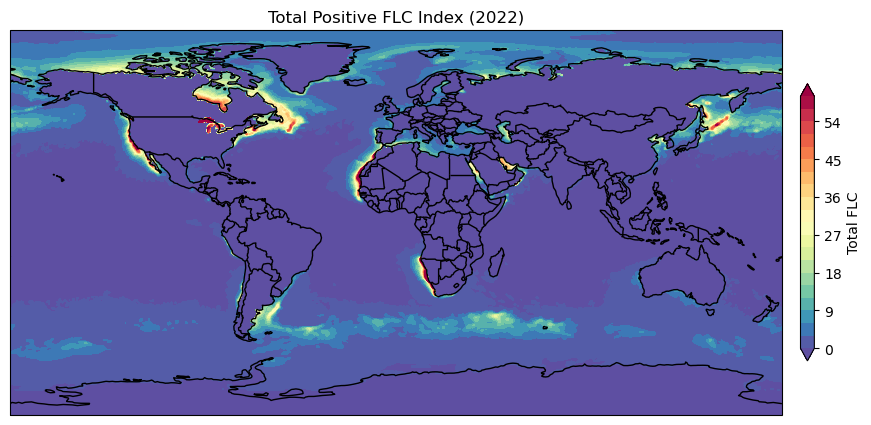

In [23]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})

#---normal settings
# cmap = plt.cm.Spectral_r
# levels = np.linspace(-np.amax(tot.flc_index), np.amax(tot.flc_index), 35)

#---Positive FLC index (negative FLC indexes are removed)
cmap = plt.cm.Spectral_r
levels = np.linspace(0, 60, 21)

c=ax.contourf(tot.longitude[0,:], tot.latitude[:,0], tot.flc_index, cmap=cmap, levels=levels, extend='both')

clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Total Positive FLC Index ('+year+')')
clb.set_label('Total FLC')

ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS)
#ax.add_feature(cfeature.STATES)

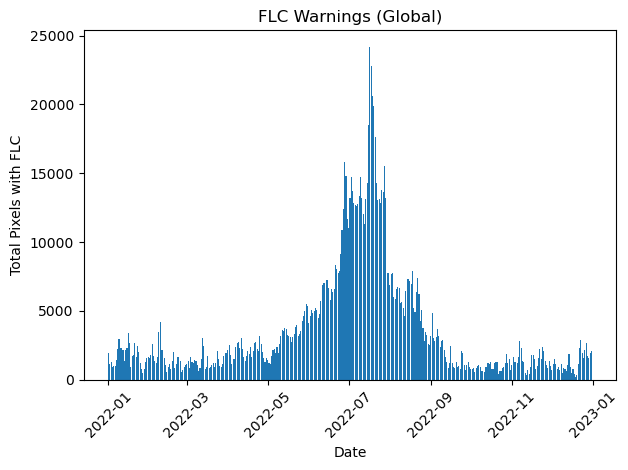

In [21]:
flc_above = []
da_tot_area = []
flc_above = da_concat.flc_index.where(da_concat.flc_index > 0.1)
da_tot_area = flc_above.sum(dim='x').sum(dim='y')

plt.bar(da_tot_area['time'], da_tot_area)

# add labels and title
plt.xlabel('Date')
plt.ylabel('Total Pixels with FLC')
plt.title('FLC Warnings (Global)')
plt.xticks(rotation=45)

plt.tight_layout()

In [22]:
da_tot_area[da_tot_area == da_tot_area.max()]

<xarray.DataArray 'flc_index' (time: 1)>
array([24176.287], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2022-07-17